**import**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Step 1: Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"

data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

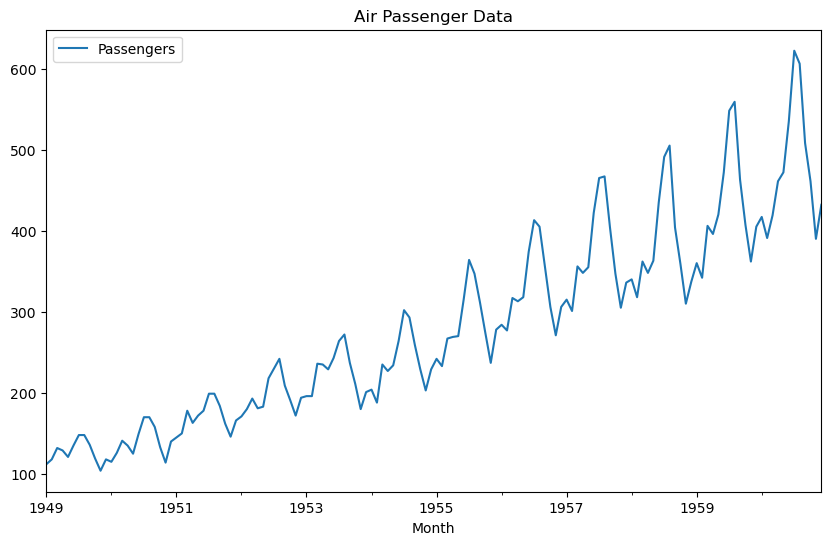

In [6]:
# Step 2: Visualize the original data
data.plot(title="Air Passenger Data", figsize=(10, 6))
plt.show()

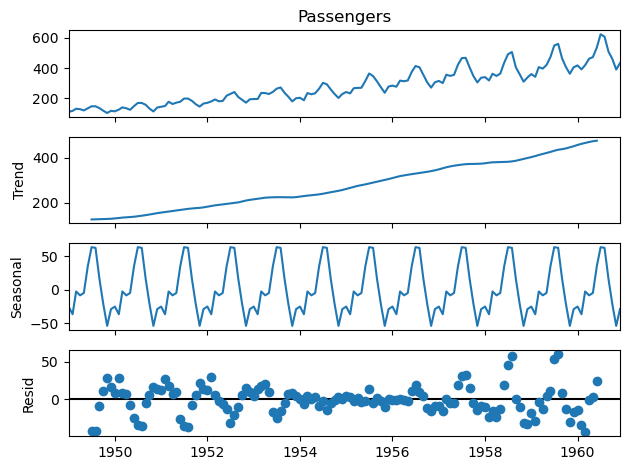

In [8]:
# Step 3: Perform time series decomposition to extract trend, seasonality, and residuals
result = seasonal_decompose(data['Passengers'], model='additive')
result.plot()
plt.show()

In [10]:
# Step 4: Apply the ARIMA model for forecasting
# Define ARIMA parameters (p, d, q)
model_arima = ARIMA(data['Passengers'], order=(4, 1, 1))

# Fit the model
arima_result = model_arima.fit()

# Generate predictions using ARIMA
data['ARIMA_Predictions'] = arima_result.predict(start=1, end=len(data), dynamic=False)

# Forecast 12 months into the future
forecast_arima = arima_result.get_forecast(steps=12)
forecast_arima_index = pd.date_range(data.index[-1], periods=12, freq='MS')
forecast_arima_values = forecast_arima.predicted_mean
forecast_arima_ci = forecast_arima.conf_int()

C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
# Step 5: Apply Exponential Smoothing for forecasting
# Define the model with trend and seasonality
model_exp = ExponentialSmoothing(data['Passengers'], 
                                 trend='additive', 
                                 seasonal='additive', 
                                 seasonal_periods=12)

# Fit the model
exp_result = model_exp.fit()

# Generate fitted values for Exponential Smoothing
data['Exp_Smoothing'] = exp_result.fittedvalues

# Forecast 12 months into the future
forecast_exp = exp_result.forecast(steps=12)

C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


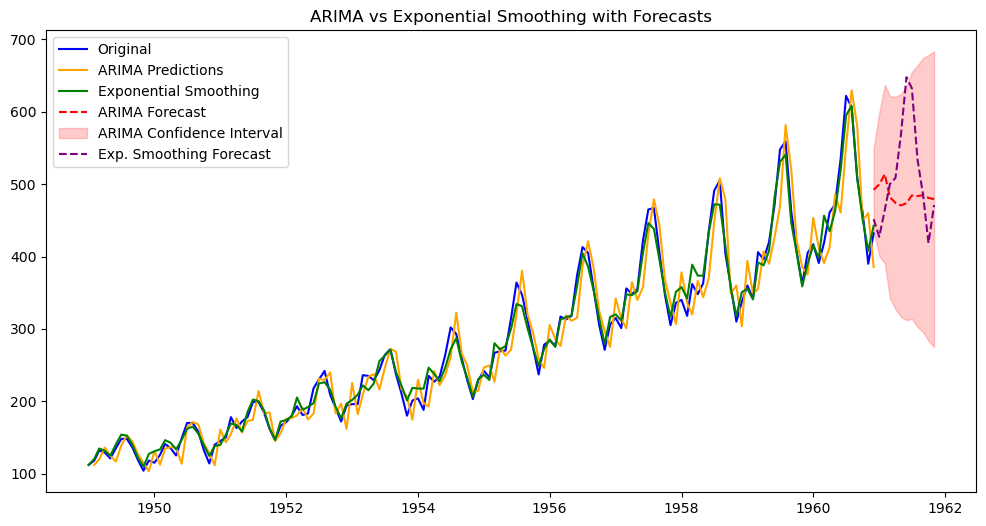

In [14]:
# Step 6: Visualize and compare predictions and forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label="Original", color='blue')  # Original data
plt.plot(data['ARIMA_Predictions'], label="ARIMA Predictions", color='orange')  # ARIMA predictions
plt.plot(data['Exp_Smoothing'], label="Exponential Smoothing", color='green')  # Exp. smoothing predictions

# Add ARIMA forecast
plt.plot(forecast_arima_index, forecast_arima_values, label="ARIMA Forecast", color='red', linestyle='dashed')
plt.fill_between(forecast_arima_index, 
                 forecast_arima_ci.iloc[:, 0], 
                 forecast_arima_ci.iloc[:, 1], 
                 color='red', alpha=0.2, label="ARIMA Confidence Interval")

# Add Exponential Smoothing forecast
plt.plot(forecast_arima_index, forecast_exp, label="Exp. Smoothing Forecast", color='purple', linestyle='dashed')

plt.legend()
plt.title("ARIMA vs Exponential Smoothing with Forecasts")
plt.show()

In [18]:
# manually making predictions

# Combine ARIMA and Exponential Smoothing forecasts into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_arima_index,
    'ARIMA_Forecast': forecast_arima_values,
    'Exp_Smoothing_Forecast': forecast_exp
}).set_index('Date')

print(f"Forecast range: {forecast_arima_index.min().date()} to {forecast_arima_index.max().date()}")

Forecast range: 1960-12-01 to 1961-11-01


In [22]:
# Function to get the forecast for a specific date
def get_forecast(date):
    date = pd.to_datetime(date)  # Ensure the input is in datetime format
    if date in forecast_df.index:
        result = forecast_df.loc[date]
        return f"Forecast for {date.date()}:\nARIMA: {result['ARIMA_Forecast']:.2f}, Exponential Smoothing: {result['Exp_Smoothing_Forecast']:.2f}"
    else:
        return "Date not in forecast range. Please provide a valid date within the forecast period."



In [24]:
# Step 1: Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"

data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssing\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 449.0467091236879


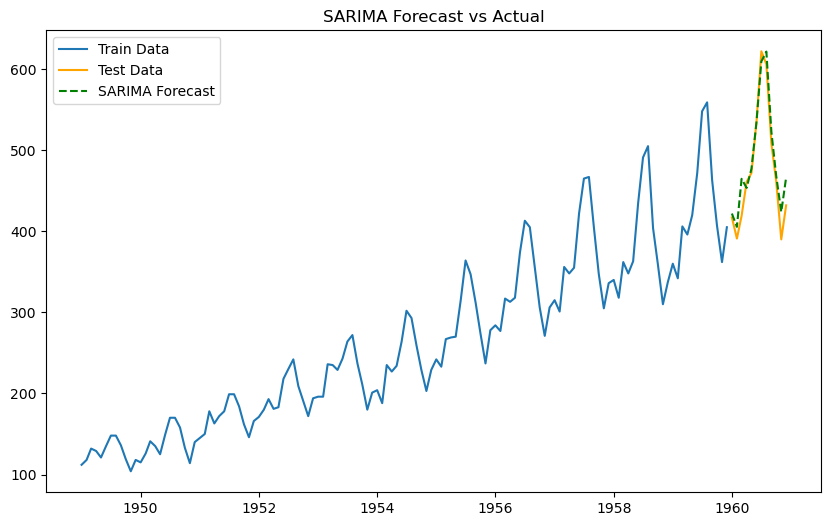

In [26]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Ensure your 'Month' column is in the correct datetime format and set as index
# Data already has 'Month' as index, so no further modification needed here

# Step 1: Split the data into train and test
train_data = data.iloc[:-12]  # Train on all data except the last 12 months
test_data = data.iloc[-12:]   # Use the last 12 months for testing

# Step 2: Fit the SARIMA model to the training data
# Set the order for the SARIMA model (p, d, q) and seasonal order (P, D, Q, S)
order = (1, 1, 1)  # (p, d, q) values, change if needed based on model tuning
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) for yearly seasonality

sarima_model = SARIMAX(train_data['Passengers'], order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)  # Fit the model, suppress output

# Step 3: Forecast for the next 12 months (test data length)
predicted_sarima = sarima_fit.forecast(steps=len(test_data))

# Step 4: Evaluate the model using Mean Squared Error
mse = mean_squared_error(test_data['Passengers'], predicted_sarima)
print(f"Mean Squared Error: {mse}")

# Step 5: Plot the predictions vs actual data
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Passengers'], label='Train Data')
plt.plot(test_data.index, test_data['Passengers'], label='Test Data', color='orange')
plt.plot(test_data.index, predicted_sarima, label='SARIMA Forecast', color='green', linestyle='--')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [29]:
# Create a sample dataframe for testing
data = pd.DataFrame({
    'Month': pd.date_range(start='1/1/2000', periods=120, freq='M'),
    'Passengers': np.random.randint(100, 500, size=120)  # Random passenger counts
})

# Set 'Month' as the index
data.set_index('Month', inplace=True)

# Display the first few rows of the dataframe
print(data.head())

            Passengers
Month                 
2000-01-31         342
2000-02-29         462
2000-03-31         386
2000-04-30         342
2000-05-31         264


C:\Users\ssing\AppData\Local\Temp\ipykernel_25220\677951534.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Month': pd.date_range(start='1/1/2000', periods=120, freq='M'),


In [32]:
# Scale the data using MinMaxScaler (scales between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Passengers'].values.reshape(-1, 1))

# Create a function to prepare the data into sequences
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time step (number of previous time steps to consider for each prediction)
time_step = 12

# Prepare the data
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be in the shape [samples, time steps, features] for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

In [34]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shapes of the prepared data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(85, 12, 1) (22, 12, 1) (85,) (22,)


In [36]:
# Initialize the model
model = Sequential()

# Add the LSTM layer with 50 units and return sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Add another Dropout layer
model.add(Dropout(0.2))

# Add the output layer with a single neuron for regression
model.add(Dense(units=1))

# Compile the model using Adam optimizer and MSE (Mean Squared Error) loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


C:\Users\ssing\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.2631
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1333 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0953 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1071 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0943 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1011 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1097 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0929 
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0956 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1006 
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0935 
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0923 
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0924 
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0889
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0856 
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions
predicted = model.predict(X)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y, predicted))
mae = mean_absolute_error(y, predicted)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
RMSE: 0.29776277774134724
MAE: 0.25661292493506527


In [42]:
# Define sequence length for LSTM
sequence_length = 60 # Number of previous days the model looks at

# Predicting the next value (after the last available data)
future_sequence = scaled_data[-sequence_length:]
future_sequence = future_sequence.reshape(1, sequence_length, 1)
predicted_value = model.predict(future_sequence)
predicted_value = scaler.inverse_transform(predicted_value)  # Rescale to original scale

print(f"Predicted value for the next day: {predicted_value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Predicted value for the next day: [[322.13483]]


In [44]:
# Number of days you want to forecast
forecast_days = 30  # Example: forecast next 30 days

# Prepare the last available sequence for prediction
last_sequence = scaled_data[-sequence_length:]
last_sequence = last_sequence.reshape(1, sequence_length, 1)

# Create a list to store the predictions
predicted_values = []

# Predict the next `forecast_days` days
for i in range(forecast_days):
    # Make the prediction
    next_day_prediction = model.predict(last_sequence)
    
    # Rescale the prediction back to original scale
    next_day_prediction = scaler.inverse_transform(next_day_prediction)
    
    # Store the predicted value
    predicted_values.append(next_day_prediction[0][0])
    
    # Update the sequence to include the new prediction (for the next day's prediction)
    last_sequence = np.append(last_sequence[:, 1:, :], next_day_prediction.reshape(1, 1, 1), axis=1)

# Convert the predictions into a DataFrame for easier viewing
predicted_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
predictions30_df = pd.DataFrame(predicted_values, index=predicted_dates, columns=['Predicted'])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [46]:
predictions30_df.head()

,Predicted
2010-01-01,322.134827
2010-01-02,383.735077
2010-01-03,435.852325
2010-01-04,474.045288
2010-01-05,501.946686


In [52]:
pip install yfinance

     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     -- ------------------------------------ 51.2/948.2 kB 1.3 MB/s eta 0:00:01
     --------- ---------------------------- 245.8/948.2 kB 3.0 MB/s eta 0:00:01
     ---------------------- --------------- 573.4/948.2 kB 4.5 MB/s eta 0:00:01
     --------------------------------- ---- 839.7/948.2 kB 4.8 MB/s eta 0:00:01
     ------------------------------------ - 921.6/948.2 kB 4.2 MB/s eta 0:00:01
     -------------------------------------- 948.2/948.2 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 

In [56]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [58]:
# Step 1: Fetch the data
stock_data = yf.download("AAPL", start="2015-01-01", end="2023-01-01", interval="1d")
data = stock_data[['Close']]
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed
C:\Users\ssing\AppData\Local\Temp\ipykernel_25220\3107118480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [60]:
# Step 2: Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for training
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [62]:
# Step 3: Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


C:\Users\ssing\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0227 - val_loss: 0.0037
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.8453e-04 - val_loss: 0.0018
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.7217e-04 - val_loss: 0.0018
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.3478e-04 - val_loss: 0.0018
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.9524e-04 - val_loss: 0.0024
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 3.4273e-04 - val_loss: 0.0016
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.8823e-04 - val_loss: 0.0016
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.8381e-04 - val_loss: 0.0022
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 2.7093e-04 - val_loss: 0.0015
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.8649e-04 - val_loss: 0.0013
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.6617e-04 - val_loss: 0.0012
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


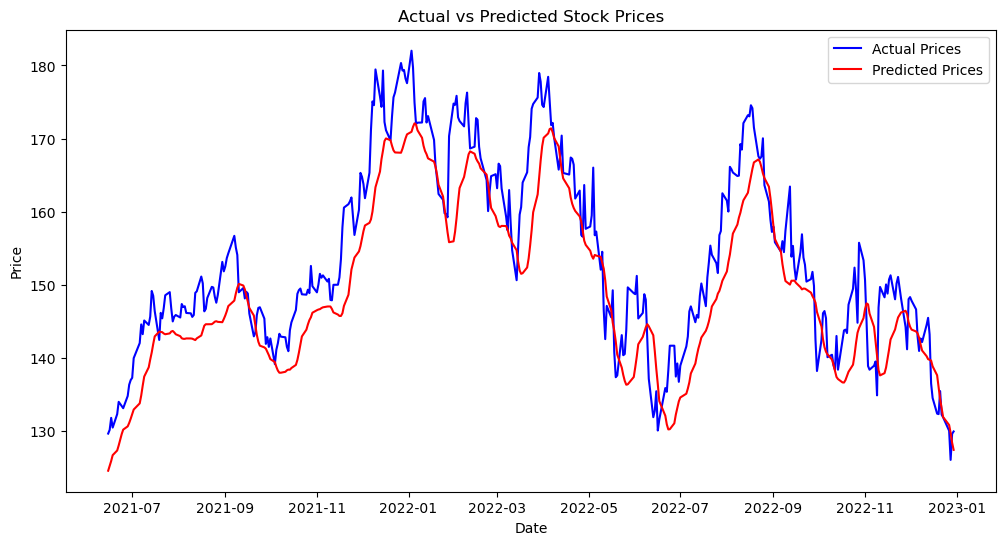

In [64]:
# Step 4: Predict test data and visualize
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, label="Actual Prices", color='blue')
plt.plot(data.index[-len(predicted):], predicted, label="Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

In [66]:
# Step 5: Forecast future stock prices
forecast_days = 30
last_sequence = scaled_data[-sequence_length:]
future_predictions = []

for _ in range(forecast_days):
    next_day_prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_day_prediction[0][0])
    last_sequence = np.append(last_sequence[1:], next_day_prediction, axis=0)

# Convert predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create a DataFrame for future predictions
forecast_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
forecast_df = pd.DataFrame(future_predictions, index=forecast_dates, columns=['Predicted Price'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

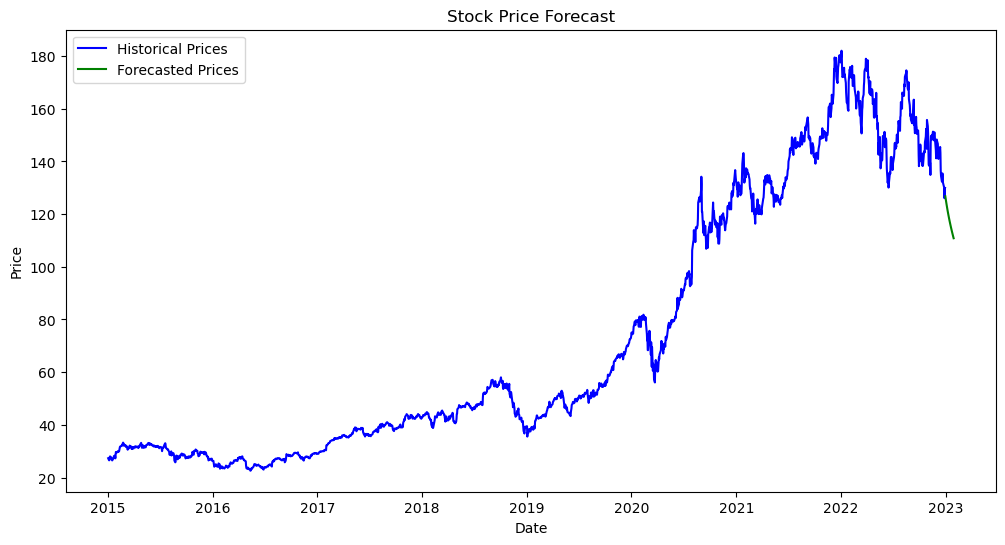

            Predicted Price
2022-12-31       126.750732
2023-01-01       126.026161
2023-01-02       125.310905
2023-01-03       124.607376
2023-01-04       123.917732
2023-01-05       123.243469
2023-01-06       122.585457
2023-01-07       121.943962
2023-01-08       121.318855
2023-01-09       120.709633
2023-01-10       120.115662
2023-01-11       119.536095
2023-01-12       118.970169
2023-01-13       118.417076
2023-01-14       117.875984
2023-01-15       117.346222
2023-01-16       116.827110
2023-01-17       116.317978
2023-01-18       115.818275
2023-01-19       115.327530
2023-01-20       114.845261
2023-01-21       114.371117
2023-01-22       113.904640
2023-01-23       113.445534
2023-01-24       112.993492
2023-01-25       112.548271
2023-01-26       112.109535
2023-01-27       111.677132
2023-01-28       111.250862
2023-01-29       110.830505


In [68]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label="Historical Prices", color='blue')
plt.plot(forecast_df.index, forecast_df['Predicted Price'], label="Forecasted Prices", color='green')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price Forecast")
plt.legend()
plt.show()

# Display forecasted prices
print(forecast_df)

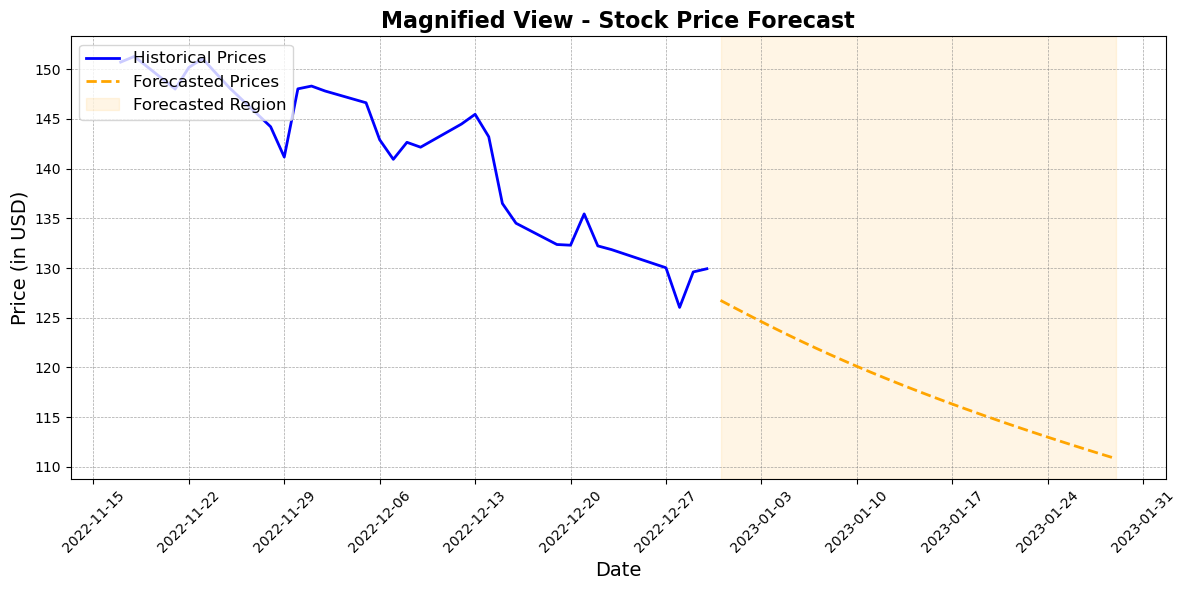

In [70]:
# Zoomed-in Plot: Last Portion of Historical Data + Predictions

import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Select a portion of historical data for context (e.g., last 30 days)
context_days = 30
historical_context = data.iloc[-context_days:]  # Slice the last N days of historical data

# Plot the historical context
plt.plot(historical_context.index, historical_context['Close'], label="Historical Prices", color='blue', linewidth=2)

# Plot the forecasted data
plt.plot(forecast_df.index, forecast_df['Predicted Price'], label="Forecasted Prices", color='orange', linestyle='--', linewidth=2)

# Highlight forecasted area with a shaded region
plt.axvspan(forecast_df.index[0], forecast_df.index[-1], color='orange', alpha=0.1, label="Forecasted Region")

# Add titles and labels
plt.title("Magnified View - Stock Price Forecast", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price (in USD)", fontsize=14)

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=45, fontsize=10)

# Add gridlines for clarity
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Add legend
plt.legend(fontsize=12, loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
